In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score
from keras.models import Sequential # type: ignore
from keras.layers import SimpleRNN, Dense, Dropout, Input # type: ignore

In [2]:
data = pd.read_csv("C:\\Users\\DELL\\Desktop\\tesla DL\\Tesla_Nasdaq_Prediction.csv")


In [3]:
# Convert 'Date' to datetime and sort by date
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date')


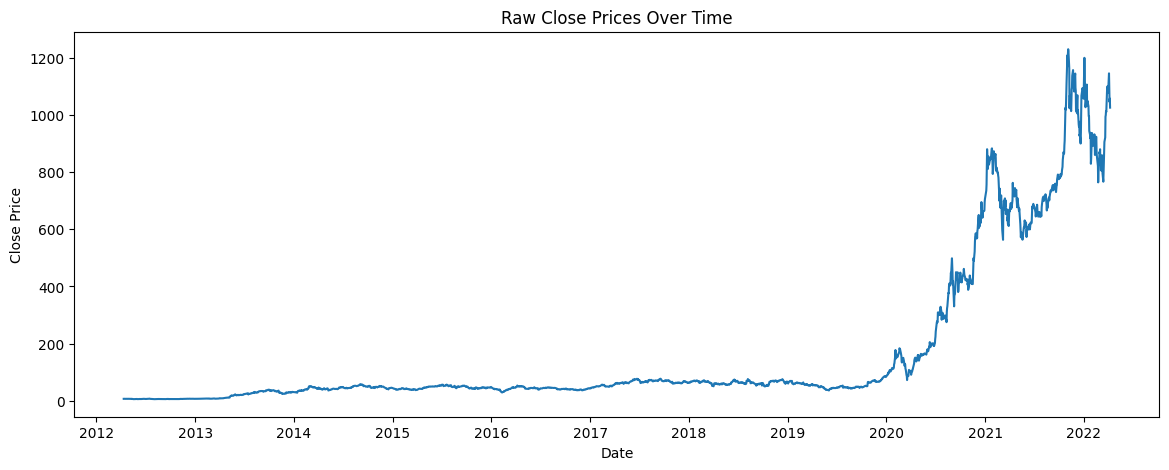

In [4]:
# Visualize the raw data
plt.figure(figsize=(14, 5))
plt.plot(data['Date'], data['Close/Last'])
plt.title('Raw Close Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

In [5]:
# Convert 'Close/Last' to string before replacing commas and converting to float
data['Close/Last'] = data['Close/Last'].astype(str).str.replace(',', '').astype(float)

In [6]:
# Proceed with the rest of the preprocessing steps
prices = data['Close/Last'].values.reshape(-1, 1)


In [7]:
# Normalize the prices
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(prices)


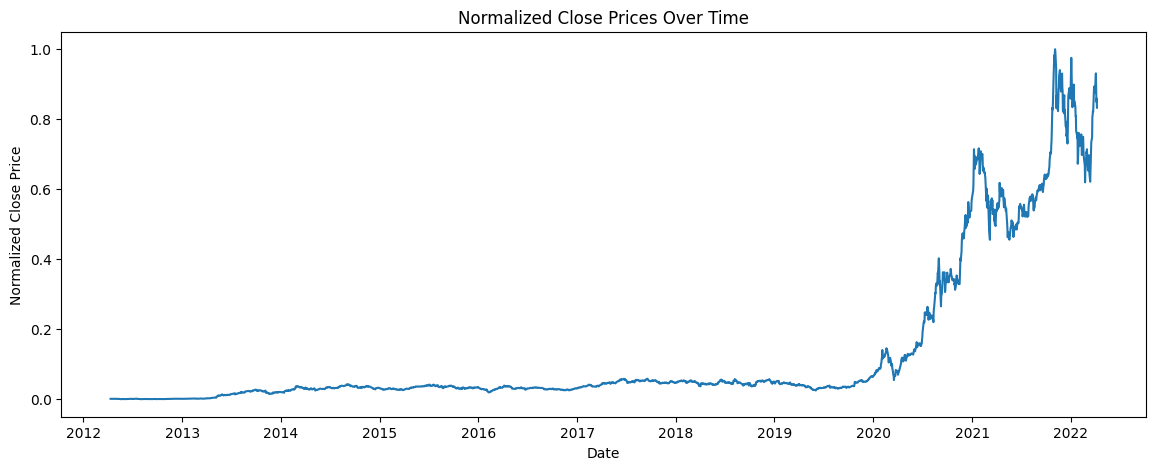

In [8]:
# Visualize the normalized data
plt.figure(figsize=(14, 5))
plt.plot(data['Date'], scaled_prices)
plt.title('Normalized Close Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Normalized Close Price')
plt.show()


In [9]:
# Create sequences for RNN
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 60  # Use 60 days of data to predict the next day's price
X, y = create_sequences(scaled_prices, seq_length)


In [10]:
# Split the data into training and testing sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

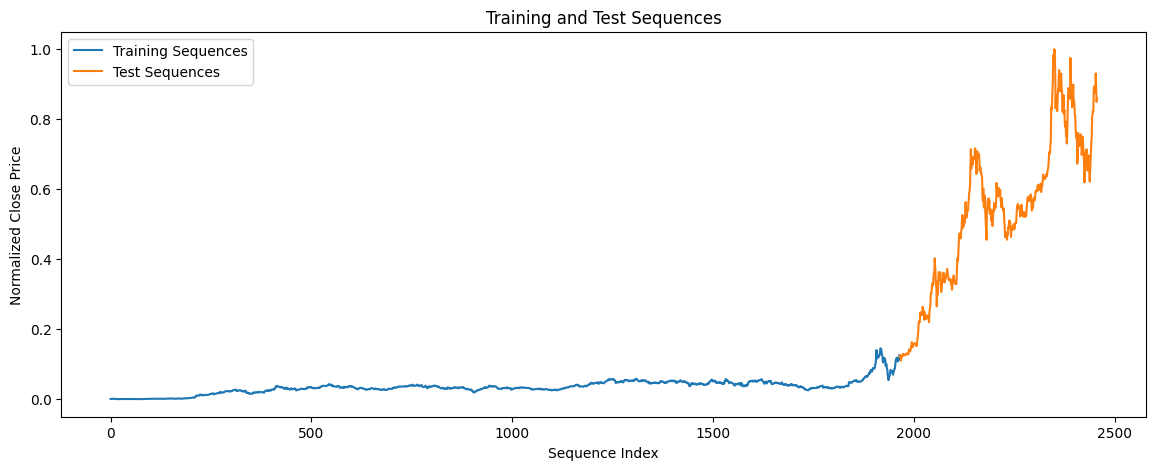

In [11]:
# Visualize the training and test sequences
plt.figure(figsize=(14, 5))
plt.plot(range(len(X_train)), X_train[:, -1, 0], label='Training Sequences')
plt.plot(range(len(X_train), len(X_train) + len(X_test)), X_test[:, -1, 0], label='Test Sequences')
plt.title('Training and Test Sequences')
plt.xlabel('Sequence Index')
plt.ylabel('Normalized Close Price')
plt.legend()
plt.show()


In [29]:
# Build the RNN model
def build_RNN_model(input_shape, neurons, dropout=0.2, loss='mse', optimizer='optimizer'):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(SimpleRNN(units=neurons, activation='tanh'))
    model.add(Dropout(dropout))
    model.add(Dense(units=1))
    model.compile(loss=loss, optimizer=optimizer)
    return model

In [30]:
# Define model parameters
neurons = 50
dropout = 0.2
loss = 'mse'
optimizer = 'adam'
epochs = 20
batch_size = 32

In [33]:
# Build the model
model = build_RNN_model((seq_length, 1), neurons, dropout, loss, optimizer)


In [34]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)


Epoch 1/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0015 - val_loss: 0.0748
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.6313e-05 - val_loss: 0.0308
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.6400e-05 - val_loss: 0.0149
Epoch 4/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.4153e-05 - val_loss: 0.0122
Epoch 5/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.4595e-05 - val_loss: 0.0097
Epoch 6/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.8872e-05 - val_loss: 0.0097
Epoch 7/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.6797e-05 - val_loss: 0.0044
Epoch 8/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.3555e-05 - val_loss: 0.0056
Epoch 9/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.9277e-05 - val_loss: 0.0040
Epoch 10/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.9580e-05 - val_loss: 0.0034
Epoch 11/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.1817e-05 - val_loss: 0.0038
Epoch 12/20
62/62 ━━━━━━━━━━━━

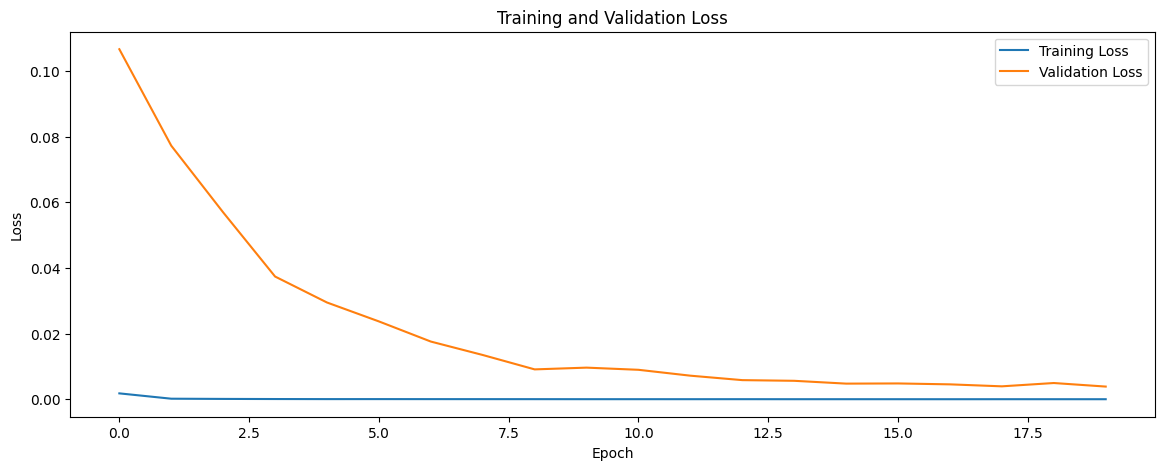

In [16]:
# Visualize training & validation loss values
plt.figure(figsize=(14, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()


In [17]:
# Evaluate the model
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)

In [18]:
# Predict and calculate accuracy
y_pred = model.predict(X_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


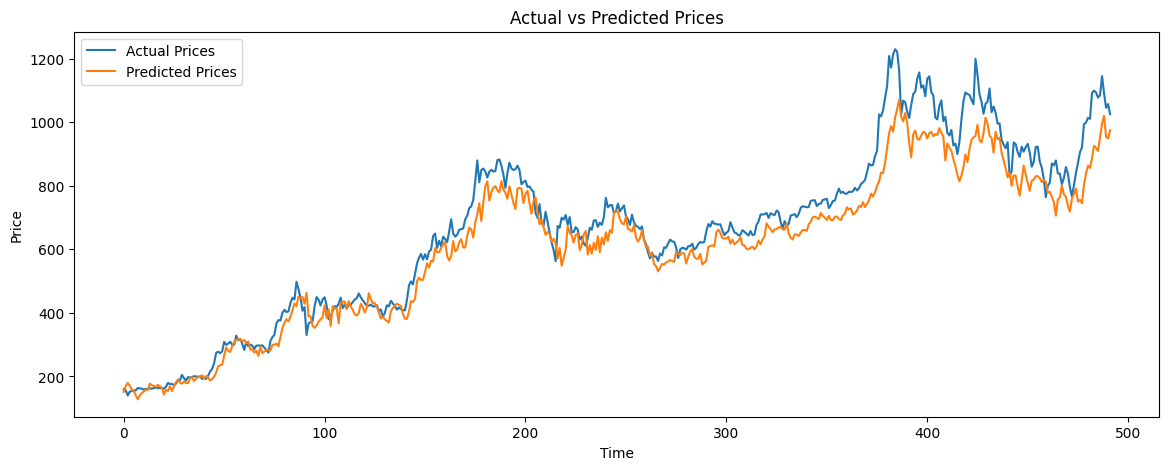

In [19]:
# Visualize the actual vs predicted prices
plt.figure(figsize=(14, 5))
plt.plot(y_test_rescaled, label='Actual Prices')
plt.plot(y_pred_rescaled, label='Predicted Prices')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs Predicted Prices')
plt.show()


In [20]:
# Calculate and visualize additional metrics
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
r2 = r2_score(y_test_rescaled, y_pred_rescaled)

print(f'Training Loss: {train_loss}')
print(f'Test Loss: {test_loss}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R²): {r2}')

Training Loss: 9.654623681853991e-06
Test Loss: 0.0038785890210419893
Mean Absolute Error (MAE): 57.520548322724125
R-squared (R²): 0.9186074697188248
